In [1]:
import sqlite3
import pandas as pd
import pylab
import collections
import numpy as np
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
from plotnine import *

In [2]:
import sqlite3 
conn = sqlite3.connect("./data/myzhihu.db")
cursor = conn.cursor()
sql = """select name from sqlite_master where type='table' order by name"""
cursor.execute(sql)
result = cursor.fetchall()
print(result)
conn.close()

[('following',), ('user_info',)]


user_info表读取

In [3]:
import sqlite3
import pandas as pd
conn = sqlite3.connect("./data/myzhihu.db")
conn.row_factory = sqlite3.Row
cursor = conn.cursor()
sql = "select * from user_info"
cursor.execute(sql)
col_name_list = [tuple[0] for tuple in cursor.description]
user_info_data = cursor.fetchall()
conn.close()

user_info_data = pd.DataFrame(user_info_data,columns=['user_url', 'user_id',  'follower_num','followee_num', 'answer_num', 'agree_num', 'thanks_num', 'is_crawled'])
user_info_data = user_info_data.dropna(axis=0,how='any')
user_info_data[['follower_num','followee_num', 'answer_num', 'agree_num', 'thanks_num']] = user_info_data[['follower_num','followee_num', 'answer_num', 'agree_num', 'thanks_num']].astype(int)
user_info_data.head()

,user_url,user_id,follower_num,followee_num,answer_num,agree_num,thanks_num,is_crawled
0,https://www.zhihu.com/people/li-jun-min-69,李牧之,12,237,55,195,15,1
1,https://www.zhihu.com/people/andy-lee-60,Andy Lee,235926,162,760,256673,48509,1
2,https://www.zhihu.com/org/a-li-yun-97-77,阿里云,89948,80,75,54632,5210,1
3,https://www.zhihu.com/people/hu-jing-70-38,古青,194759,903,932,1985038,183333,1
4,https://www.zhihu.com/people/xiaokeer,小可可,12822,4,79,57393,6801,1


In [4]:
add_data = pd.read_csv('./data/user_info.csv',encoding='utf-8')
add_data = add_data.drop(['layer'],axis=1)
# add_data = pd.DataFrame(add_data,columns=['user_url', 'user_id',  'follower_num','followee_num', 'answer_num', 'agree_num', 'thanks_num', 'is_crawled'])
# add_data = add_data.rename({'followee_num':'follower_num','follower_num':'followee_num'})
add_data.columns=['user_url', 'user_id',  'follower_num','followee_num', 'answer_num', 'agree_num', 'thanks_num', 'is_crawled']
add_data.head()

,user_url,user_id,follower_num,followee_num,answer_num,agree_num,thanks_num,is_crawled
0,https://www.zhihu.com/people/zhangxiuying,老猫仙,79657,208,1011,204619,27076,0
1,https://www.zhihu.com/people/hebo-21,Hebo,2226,465,10,551,97,0
2,https://www.zhihu.com/people/tian-gu-niang-22,冰柠檬,7504,5994,256,9984,4270,0
3,https://www.zhihu.com/people/clickstone,谷文栋,17495,134,68,5094,608,0
4,https://www.zhihu.com/people/liu-li-38-6-80,琉璃,1470,60,24,6800,903,0


In [5]:
#拼接并去重
user_info_data = pd.concat([user_info_data,add_data],ignore_index=True)
user_info_data.drop_duplicates(['user_url'],keep='first',inplace=True)
user_info_data.head()

,user_url,user_id,follower_num,followee_num,answer_num,agree_num,thanks_num,is_crawled
0,https://www.zhihu.com/people/li-jun-min-69,李牧之,12,237,55,195,15,1
1,https://www.zhihu.com/people/andy-lee-60,Andy Lee,235926,162,760,256673,48509,1
2,https://www.zhihu.com/org/a-li-yun-97-77,阿里云,89948,80,75,54632,5210,1
3,https://www.zhihu.com/people/hu-jing-70-38,古青,194759,903,932,1985038,183333,1
4,https://www.zhihu.com/people/xiaokeer,小可可,12822,4,79,57393,6801,1


In [6]:
# 剔除回答数为0却有赞同数的作者
user_info_data.drop(user_info_data.index[(user_info_data['answer_num'] == 0) & (user_info_data['agree_num'] > 0)], inplace=True)

In [7]:
len(user_info_data)

9747

In [8]:
user_info_data[user_info_data.follower_num>=120000000]

,user_url,user_id,follower_num,followee_num,answer_num,agree_num,thanks_num,is_crawled
148,https://www.zhihu.com/org/zhi-hu-ri-bao-51-41,知乎日报,124295015,241,17,958950,80599,1


In [9]:
user_info_data[user_info_data.followee_num==max(user_info_data.followee_num)]

,user_url,user_id,follower_num,followee_num,answer_num,agree_num,thanks_num,is_crawled
6005,https://www.zhihu.com/people/chen-guang-55,盖比老师,101913,101868,544,196346,29471,0


In [10]:
#剔除知乎日报
user_info_data.drop([148,],inplace = True)
user_info_data.head()

,user_url,user_id,follower_num,followee_num,answer_num,agree_num,thanks_num,is_crawled
0,https://www.zhihu.com/people/li-jun-min-69,李牧之,12,237,55,195,15,1
1,https://www.zhihu.com/people/andy-lee-60,Andy Lee,235926,162,760,256673,48509,1
2,https://www.zhihu.com/org/a-li-yun-97-77,阿里云,89948,80,75,54632,5210,1
3,https://www.zhihu.com/people/hu-jing-70-38,古青,194759,903,932,1985038,183333,1
4,https://www.zhihu.com/people/xiaokeer,小可可,12822,4,79,57393,6801,1


## 基本统计量分析

### 1、知乎用户的基本指标统计

In [28]:
round(user_info_data.describe()[[ 'follower_num','followee_num', 'answer_num', 'agree_num', 'thanks_num']].T,0)

,count,mean,std,min,25%,50%,75%,max
follower_num,9746.0,62516.0,261324.0,1.0,927.0,6644.0,41782.0,11718633.0
followee_num,9746.0,380.0,1324.0,0.0,35.0,121.0,339.0,101868.0
answer_num,9746.0,275.0,792.0,1.0,18.0,68.0,231.0,28376.0
agree_num,9746.0,94925.0,357407.0,1.0,906.0,7328.0,51144.0,9525541.0
thanks_num,9746.0,17746.0,83499.0,1.0,182.0,1379.0,9338.0,4450740.0


In [31]:
user_info_data.rename(columns={'thanks_num':'likes_num'},inplace=True)

In [32]:
user_info_data

,user_url,user_id,follower_num,followee_num,answer_num,agree_num,likes_num,is_crawled
0,https://www.zhihu.com/people/li-jun-min-69,李牧之,12,237,55,195,15,1
1,https://www.zhihu.com/people/andy-lee-60,Andy Lee,235926,162,760,256673,48509,1
2,https://www.zhihu.com/org/a-li-yun-97-77,阿里云,89948,80,75,54632,5210,1
3,https://www.zhihu.com/people/hu-jing-70-38,古青,194759,903,932,1985038,183333,1
4,https://www.zhihu.com/people/xiaokeer,小可可,12822,4,79,57393,6801,1
...,...,...,...,...,...,...,...,...
10699,https://www.zhihu.com/people/lu-shi-han-89,卢诗翰,89691,1576,297,466399,66684,1
10700,https://www.zhihu.com/people/chenran,陈然,210484,5226,847,97688,19670,1
10701,https://www.zhihu.com/people/douzishushu,豆子,653992,106,1237,2838534,382862,1
10702,https://www.zhihu.com/people/xpqiu,邱锡鹏,51345,183,54,22529,2885,1


### 2、粉丝数分段

In [14]:
follower_num_list = pd.to_numeric(user_info_data['follower_num']).tolist()
follower_num_range=pd.cut(follower_num_list,[0,100,1000,10000,100000,124295016], labels=[u"(0,100]",u"(100,1k]",u"(1k,1w]",u"(1w,10w]",u"10w+"])

In [15]:
follower_num_range.value_counts()

(0,100]      952
(100,1k]    1556
(1k,1w]     2892
(1w,10w]    2998
10w+        1348
dtype: int64

In [33]:
def plot_user_distribution(feature,x_start,x_end,x_num,y_start,y_end,y_num):    
    plt.figure(1)
    plt.title("Distribution of " + feature + ' to Individual User')
    plt.xlabel("Individual User(sum=9746)")
    plt.ylabel(feature + " of user")
    user = list(range(len(user_info_data)))
    feature_value = sorted(list(user_info_data[feature]), reverse=True)#DataFrame -> list -> do sort
    plt.scatter(user, feature_value, edgecolors='black',c='midnightblue', s= 5)
    plt.xticks(np.linspace(x_start,x_end,x_num,endpoint=True), fontsize=10)
    plt.yticks(np.linspace(y_start,y_end,y_num,endpoint=True), fontsize=10)
    print('mean of', feature, np.mean(list(user_info_data[feature])))
    print('median of', feature, np.median(list(user_info_data[feature])))
    print('standard deviation of', np.std(list(user_info_data[feature])), '\n')

    plt.show()

mean of followee_num 380.1705315001026
median of followee_num 121.0
standard deviation of 1324.2995635976574 



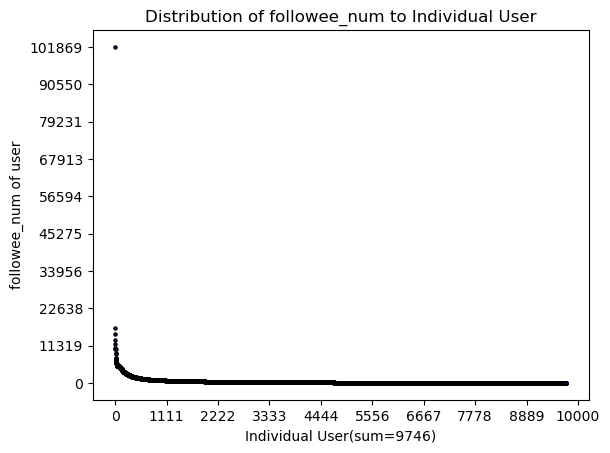

In [77]:
plot_user_distribution('followee_num',0,10000,10,0,101869,10)

mean of follower_num 62515.601887954035
median of follower_num 6644.5
standard deviation of 261310.83723733056 



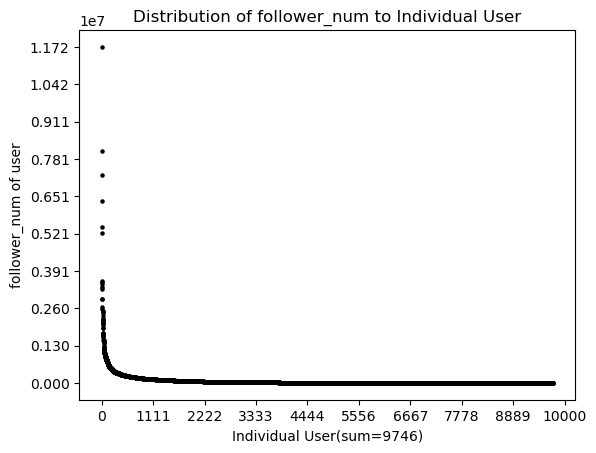

In [63]:
plot_user_distribution('follower_num',0,10000,10,0,11718634,10)

mean of answer_num 274.5643340857788
median of answer_num 68.0
standard deviation of 792.2700374539827 



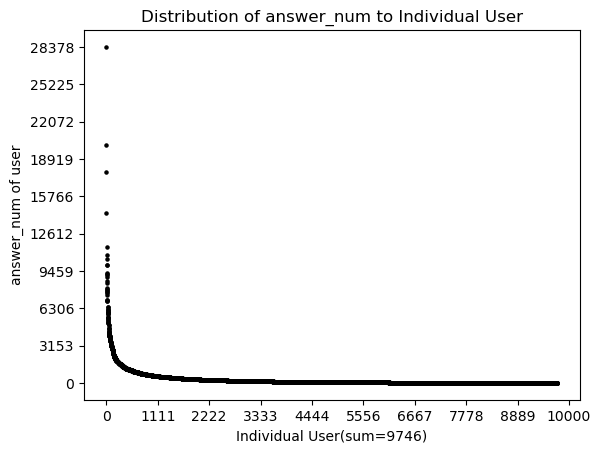

In [69]:
plot_user_distribution('answer_num',0,10000,10,0,28378,10)

mean of agree_num 94924.87605171352
median of agree_num 7327.5
standard deviation of 357388.20703187404 



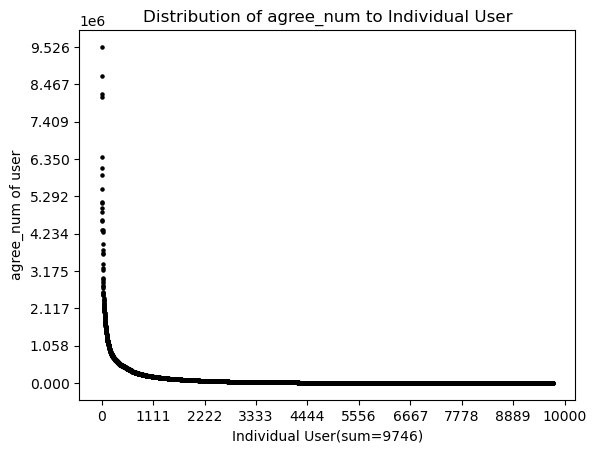

In [71]:
plot_user_distribution('agree_num',0,10000,10,0,9525542,10)

mean of likes_num 17745.572439975374
median of likes_num 1379.0
standard deviation of 83494.56467910438 



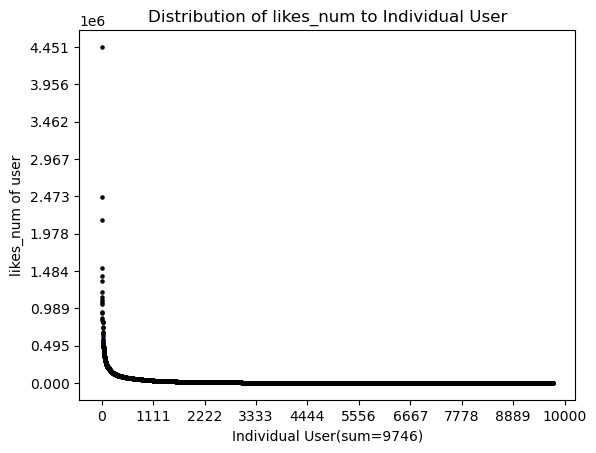

In [36]:
plot_user_distribution('likes_num',0,10000,10,0,4450741,10)

In [34]:
def plot_user_summary_log_log_distribution(feature):
    plt.figure('log-log ' + feature)
    plt.title('Log-log Distribution of ' + feature + ' to User Count')
    plt.xlabel(feature + ' Count(log10)')
    plt.ylabel("User Count(log10)")
    feature_count_pairs = collections.Counter(list(user_info_data[feature])).most_common()
    feature_value = np.log10(list(zip(*feature_count_pairs))[0])
    user_count = np.log10(list(zip(*feature_count_pairs))[1])
    plt.scatter(feature_value, user_count,color='black', s= 5)

    plt.show()

<ipython-input-64-b0bff9d1ac7f>:7: RuntimeWarning: divide by zero encountered in log10


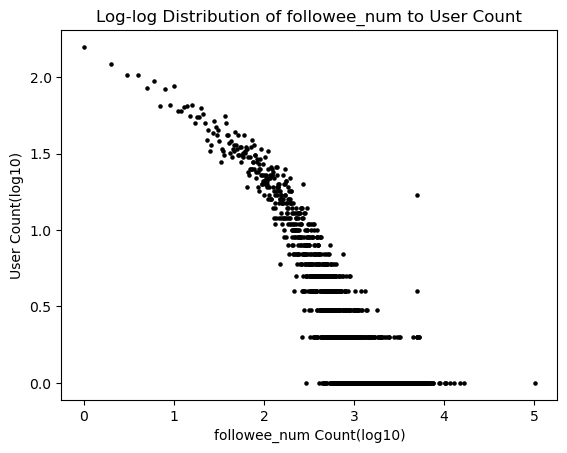

In [68]:
plot_user_summary_log_log_distribution('followee_num')

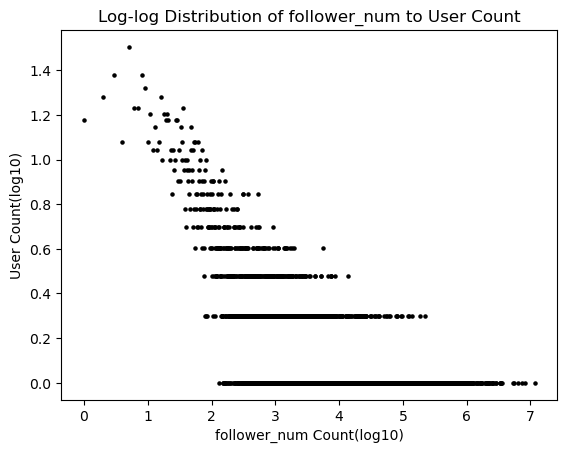

In [65]:
plot_user_summary_log_log_distribution('follower_num')

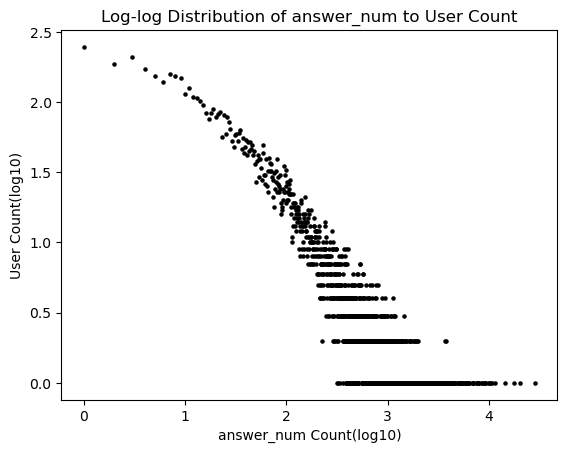

In [70]:
plot_user_summary_log_log_distribution('answer_num')

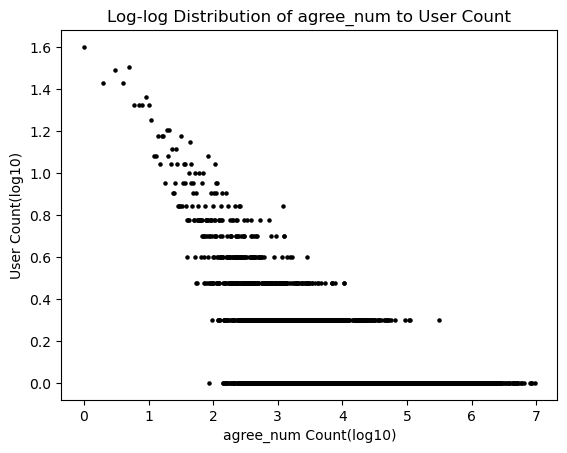

In [72]:
plot_user_summary_log_log_distribution('agree_num')

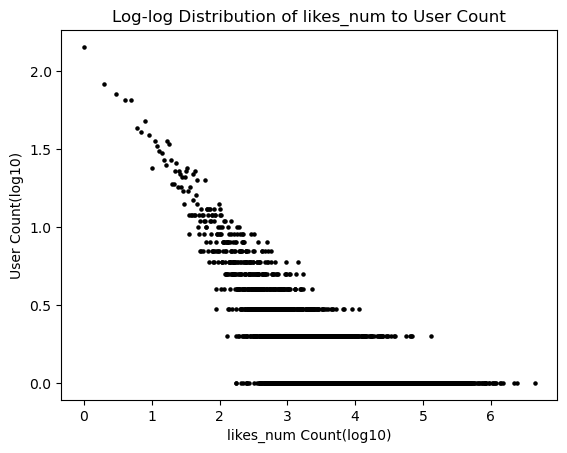

In [35]:
plot_user_summary_log_log_distribution('likes_num')

### 2、赞同数分段

In [20]:
agree_num_list = pd.to_numeric(user_info_data['agree_num']).tolist()
agree_num_range=pd.cut(agree_num_list,[0,100,1000,10000,100000,124295016], labels=[u"(0,100]",u"(100,1k]",u"(1k,1w]",u"(1w,10w]",u"10w+"])

In [21]:
agree_num_range.value_counts()

(0,100]      941
(100,1k]    1582
(1k,1w]     2769
(1w,10w]    2766
10w+        1688
dtype: int64

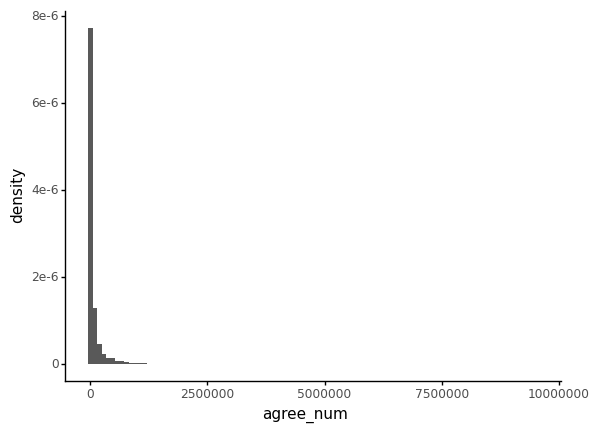

<ggplot: (133396987697)>

In [22]:
ggplot(user_info_data, aes(x='agree_num', y=after_stat('density'))) + geom_histogram(bins=100) + theme_classic()

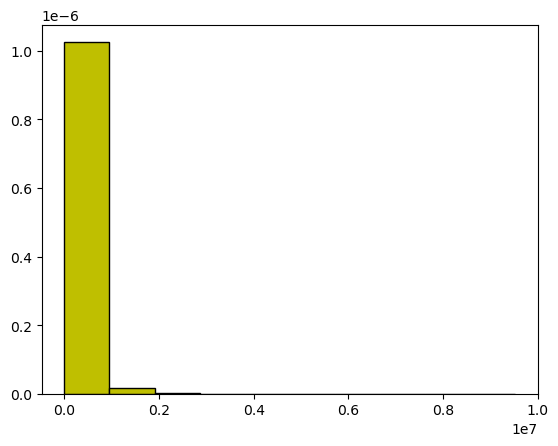

In [16]:
plt.hist(user_info_data.agree_num, bins = 10, density = True, color = 'y', edgecolor='k')
plt.show()

mean of agree_num 94924.87605171352
median of agree_num 7327.5
standard deviation of 357388.20703187404 



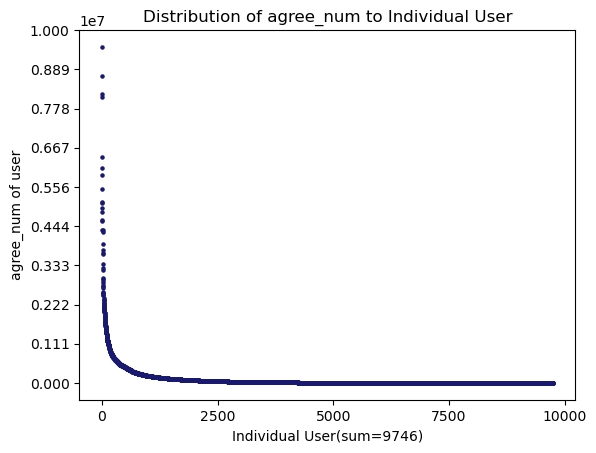

In [58]:
plot_user_distribution('agree_num',0,10000,5,0,10000000,10)

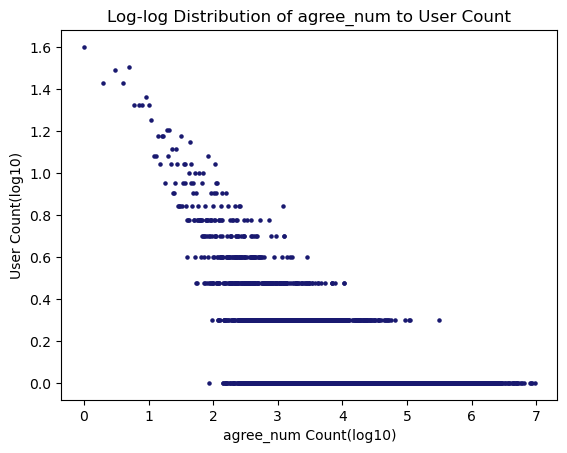

In [59]:
plot_user_summary_log_log_distribution('agree_num')

### 头腰尾分级

In [11]:
user_info_data['avg_agree'] = user_info_data['agree_num']/user_info_data['answer_num']

In [12]:
user_info_data.head()

,user_url,user_id,follower_num,followee_num,answer_num,agree_num,thanks_num,is_crawled,avg_agree
0,https://www.zhihu.com/people/li-jun-min-69,李牧之,12,237,55,195,15,1,3.545455
1,https://www.zhihu.com/people/andy-lee-60,Andy Lee,235926,162,760,256673,48509,1,337.727632
2,https://www.zhihu.com/org/a-li-yun-97-77,阿里云,89948,80,75,54632,5210,1,728.426667
3,https://www.zhihu.com/people/hu-jing-70-38,古青,194759,903,932,1985038,183333,1,2129.869099
4,https://www.zhihu.com/people/xiaokeer,小可可,12822,4,79,57393,6801,1,726.493671


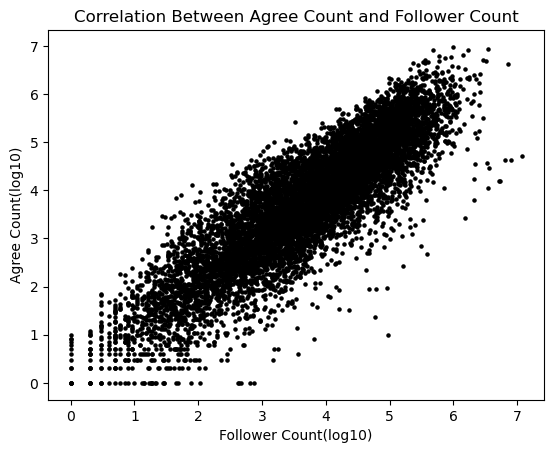

In [27]:
agree_num = np.log10(list(user_info_data['agree_num']))
follower_num = np.log10(list(user_info_data['follower_num']))

plt.figure('agree and follower')    
plt.title('Correlation Between Agree Count and Follower Count')
plt.xlabel('Follower Count(log10)')
plt.ylabel("Agree Count(log10)")  
plt.scatter(follower_num, agree_num,color='k', s= 5)

plt.show()

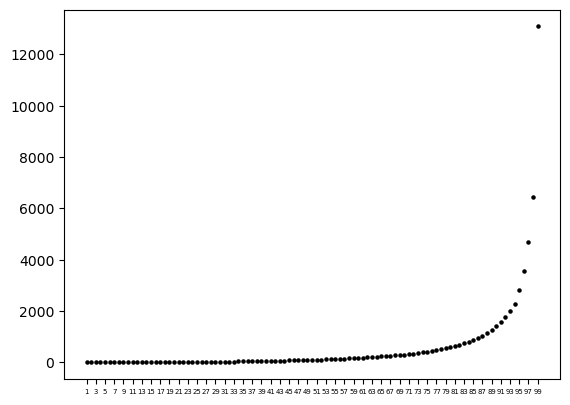

In [13]:
avg_agree_range = []
for i in range(1,100,1):
    avg_agree_range.append(np.percentile(user_info_data['avg_agree'], i))
    
plt.scatter(range(1,100,1),avg_agree_range,c='k',s=5)
plt.xticks(range(1,100,2), fontsize=5)
plt.show()

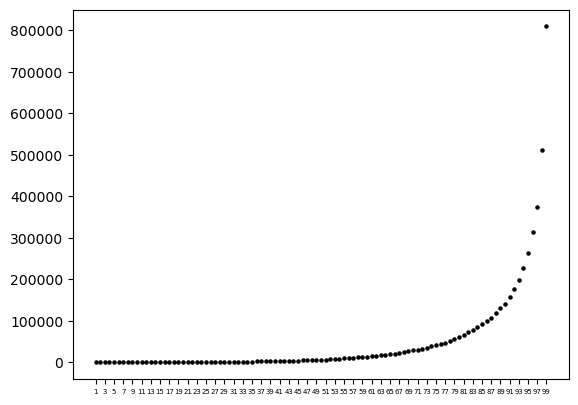

In [37]:
avg_agree_range = []
for i in range(1,100,1):
    avg_agree_range.append(np.percentile(user_info_data['follower_num'], i))
    
plt.scatter(range(1,100,1),avg_agree_range,c='k',s=5)
plt.xticks(range(1,100,2), fontsize=5)
plt.show()

In [47]:
pd.DataFrame(avg_agree_range)

,0
0,5.00
1,11.00
2,18.00
3,26.00
4,34.00
...,...
94,262655.00
95,313559.00
96,373982.95
97,512326.90


In [53]:
user_auth_data = user_info_data[user_info_data['user_id'].isin(['肥肥猫','河森堡','朱炫','梁边妖','马伯庸','李松蔚','知乎小管家','曾加','葛巾','丁香医生'])]

In [56]:
user_auth_data.to_csv('./data/user_auth_data.csv', index=False, header = True,encoding = 'utf-8-sig')

头部作者定义：平均赞同数在95分位数以上  
腰部作者定义：平均赞同数在80分位数以上，95分位数一下

In [14]:
# 头部作者数量
top_user_num = len(user_info_data[user_info_data['avg_agree']>=np.percentile(user_info_data['avg_agree'], 95)])
# 腰部作者数量
waist_user_num = len(user_info_data[user_info_data['avg_agree']>np.percentile(user_info_data['avg_agree'], 80)]) - top_user_num
print(top_user_num)
print(waist_user_num)

488
1461


In [15]:
len(user_info_data)-top_user_num-waist_user_num

7797

## 社交关系分析

### following表

In [11]:
import sqlite3
conn = sqlite3.connect("./data/myzhihu.db")
conn.row_factory = sqlite3.Row
cursor = conn.cursor()
sql = "select distinct c.user_id as source_id,c.followee_num as source_follower_num,c.follower_num as source_followee_num,c.answer_num as source_answer_num,c.agree_num as source_agree_num,c.thanks_num as source_thanks_num,\
        b.user_id as target_id,b.followee_num as target_follower_num,b.follower_num as target_followee_num,b.answer_num as target_answer_num,b.agree_num as target_agree_num,b.thanks_num as target_thanks_num\
        from following a                                                   \
        left join                                                          \
        (select * from user_info where is_crawled=1) b                     \
        on a.followee_url = b.user_url                                     \
        left join                                                          \
        (select * from user_info where is_crawled=1) c                     \
        on a.user_url = c.user_url                                     \
        "
cursor.execute(sql)
col_name_list = [tuple[0] for tuple in cursor.description]
following_data = cursor.fetchall()
conn.close()
following_data = pd.DataFrame(following_data,columns=col_name_list)
following_data = following_data.dropna(axis=0,how='any')
following_data.head()

,source_id,source_follower_num,source_followee_num,source_answer_num,source_agree_num,source_thanks_num,target_id,target_follower_num,target_followee_num,target_answer_num,target_agree_num,target_thanks_num
0,李牧之,12,237,55,195,15,TiMi频道,161.0,78.0,224.0,222.0,78.0
1,李牧之,12,237,55,195,15,李启方,176420.0,37.0,685.0,219770.0,146227.0
2,李牧之,12,237,55,195,15,傅宇彤,23257.0,458.0,210.0,6834.0,3136.0
4,李牧之,12,237,55,195,15,程晓华,18709.0,45.0,782.0,7475.0,3010.0
5,李牧之,12,237,55,195,15,刘宝红,16479.0,4.0,0.0,6079.0,1804.0


In [12]:
following_add_data = pd.read_csv('./data/following.csv',encoding='utf-8')
following_add_data.head()

,user_url,followee_url
0,https://www.zhihu.com/people/verycool,https://www.zhihu.com/people/1ge-qiu-zhi
1,https://www.zhihu.com/people/verycool,https://www.zhihu.com/people/sss-95-45-94
2,https://www.zhihu.com/people/verycool,https://www.zhihu.com/people/St.Pancras
3,https://www.zhihu.com/people/verycool,https://www.zhihu.com/people/jixin
4,https://www.zhihu.com/people/verycool,https://www.zhihu.com/people/zhouyuan


In [13]:
following_add_data = pd.merge(following_add_data,add_data,on='user_url',how='left')
following_add_data.columns = ['source_url','user_url','user_id','follower_num','followee_num','answer_num','agree_num','thanks_num','is_crawled']
following_add_data = pd.merge(following_add_data,add_data,on='user_url',how='left')
following_add_data = following_add_data.drop(['source_url','user_url','is_crawled_x','is_crawled_y'],axis=1)
following_add_data.columns = ['source_id', 'source_follower_num', 'source_followee_num', \
       'source_answer_num', 'source_agree_num', 'source_thanks_num', \
       'target_id', 'target_follower_num', 'target_followee_num', \
       'target_answer_num', 'target_agree_num', 'target_thanks_num']
following_add_data.head()

,source_id,source_follower_num,source_followee_num,source_answer_num,source_agree_num,source_thanks_num,target_id,target_follower_num,target_followee_num,target_answer_num,target_agree_num,target_thanks_num
0,知一声,139949,6,8,37427,4653,NaN,NaN,NaN,NaN,NaN,NaN
1,知一声,139949,6,8,37427,4653,NaN,NaN,NaN,NaN,NaN,NaN
2,知一声,139949,6,8,37427,4653,知乎机构号团队,107809.0,14.0,6.0,9404.0,1215.0
3,知一声,139949,6,8,37427,4653,黄继新,996085.0,10567.0,781.0,96099.0,25091.0
4,知一声,139949,6,8,37427,4653,周源,1016224.0,2040.0,359.0,82571.0,17213.0


In [14]:
#拼接并去重 删失
following_data = pd.concat([following_data,following_add_data],ignore_index=True)
following_data.dropna(how='any', axis=0, inplace=True)  ##删失
following_data.drop_duplicates(['source_id','target_id'],keep='first',inplace=True)  ## 去重

# 剔除回答数为0却有赞同数的作者
following_data.drop(following_data.index[(following_data['source_answer_num'] == 0) & (following_data['source_agree_num'] > 0)], inplace=True)
following_data.drop(following_data.index[(following_data['target_answer_num'] == 0) & (following_data['target_agree_num'] > 0)], inplace=True)

following_data.head()

,source_id,source_follower_num,source_followee_num,source_answer_num,source_agree_num,source_thanks_num,target_id,target_follower_num,target_followee_num,target_answer_num,target_agree_num,target_thanks_num
0,李牧之,12,237,55,195,15,TiMi频道,161.0,78.0,224.0,222.0,78.0
1,李牧之,12,237,55,195,15,李启方,176420.0,37.0,685.0,219770.0,146227.0
2,李牧之,12,237,55,195,15,傅宇彤,23257.0,458.0,210.0,6834.0,3136.0
3,李牧之,12,237,55,195,15,程晓华,18709.0,45.0,782.0,7475.0,3010.0
5,李牧之,12,237,55,195,15,AlexandeR,8283.0,28.0,587.0,8510.0,9610.0


In [16]:
len(following_data)

510579

In [17]:
following_data.to_csv('./data/for_zhuohui_following_data.txt', sep='\t',index=False, header = True)

### 1、筛选两个子集

#### 头部作者

In [35]:
following_data['source_avg_agree'] = following_data['source_agree_num']/following_data['source_answer_num'] 
following_data['target_avg_agree'] = following_data['target_agree_num']/following_data['target_answer_num'] 

In [36]:
top_following_data =  following_data[\
                (following_data['source_avg_agree']>= np.percentile(user_info_data['avg_agree'], 95)) \
                &(following_data['target_avg_agree']>= np.percentile(user_info_data['avg_agree'], 95))] 

In [37]:
# 全部数据进行乱序后写入all_data.txt

data_list_path = "./data/"
all_data_path = data_list_path + "top_following_data.txt"

with open(all_data_path, 'w') as f:
    f.seek(0)
    f.truncate()

top_following_data.to_csv(all_data_path, sep='\t',index=False, header = True)

In [38]:
len(np.union1d(top_following_data.loc[:, 'source_id'], top_following_data.loc[:, 'target_id']))

430

In [39]:
len(top_following_data)

3791

In [40]:
top_following_data.head()

,source_id,source_follower_num,source_followee_num,source_answer_num,source_agree_num,source_thanks_num,target_id,target_follower_num,target_followee_num,target_answer_num,target_agree_num,target_thanks_num,source_avg_agree,target_avg_agree
305,李松蔚,242,1607172,192,775247,169121,陈佩斯,3.0,196441.0,6.0,130219.0,13357.0,4037.744792,21703.166667
377,Lachel,764,303674,69,438446,124327,丁香医生,312.0,3276017.0,763.0,4845800.0,1067088.0,6354.289855,6350.982962
378,Lachel,764,303674,69,438446,124327,李松蔚,242.0,1607172.0,192.0,775247.0,169121.0,6354.289855,4037.744792
379,Lachel,764,303674,69,438446,124327,知乎日报,241.0,124295015.0,17.0,958950.0,80599.0,6354.289855,56408.823529
381,Lachel,764,303674,69,438446,124327,温义飞,247.0,890314.0,181.0,577580.0,114780.0,6354.289855,3191.049724


### 腰部作者

In [41]:
waist_following_data =  following_data[\
                (following_data['source_avg_agree']>= np.percentile(user_info_data['avg_agree'], 80)) \
                &(following_data['target_avg_agree']>= np.percentile(user_info_data['avg_agree'], 80)) \
                &(following_data['source_avg_agree']< np.percentile(user_info_data['avg_agree'], 95)) \
                &(following_data['target_avg_agree']< np.percentile(user_info_data['avg_agree'], 95))] 

In [42]:
len(waist_following_data)

33326

In [43]:
len(np.union1d(waist_following_data.loc[:,'source_id'], waist_following_data.loc[:, 'target_id']))

1418

In [44]:
# 全部数据进行乱序后写入all_data.txt

data_list_path = "./data/"
all_data_path = data_list_path + "waist_following_data.txt"

with open(all_data_path, 'w') as f:
    f.seek(0)
    f.truncate()

waist_following_data.to_csv(all_data_path, sep='\t',index=False, header = True)